<a href="https://colab.research.google.com/github/nmamie/ML4H_Project1/blob/master/ML4H_Project1_Task1_Nici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Heart Disease Prediction**

## Preparation

In [75]:
## basic packages
import pandas as pd
import numpy as np
import math
from IPython.display import display

In [76]:
## setup
import warnings
warnings.filterwarnings("ignore")

path = "/content/drive/MyDrive/1) ETH/3) ML in Healthcare/5) Assignments/Project 1/Data Heart Failure/"

In [77]:
## data import
train_val_data = pd.read_csv(path + "train_val_split.csv")
test_data = pd.read_csv(path + "test_split.csv")

## **Q1: Exploratory Data Analysis**

### Basic checks

In [ ]:
## examine head
train_val_data.head()

In [ ]:
## check dataset sample size & dimensionality
n = len(train_val_data)
p = len(train_val_data.columns) - 1
print("No. of samples:  ", n)
print("No. of features: ", p)

In [ ]:
## check for missing data
train_val_data.isnull().sum()

**Conclusions:**
*   We have significantly more observations than variables. Hence, no further problems arise.
*   There are no missing values.

**Implications:**
*   None

### Data types and distributions of variables

In [ ]:
## explore feature data types
train_val_data.dtypes

*FastingBS* and *HeartDisease* are binary, hence change to data type "object"

In [78]:
## change data type of categorical variables to "object"
train_val_data["FastingBS"] = train_val_data["FastingBS"].astype("object")
train_val_data["HeartDisease"] = train_val_data["HeartDisease"].astype("object")

In [79]:
# save variable & names
fts = train_val_data.drop("HeartDisease", axis=1).columns.tolist()
num_fts = train_val_data.drop("HeartDisease", axis=1).select_dtypes(exclude="object").columns.tolist()
cat_fts = train_val_data.drop("HeartDisease", axis=1).select_dtypes(include="object").columns.tolist()
num_vars = train_val_data.select_dtypes(include="int64").columns.tolist()
cat_vars = train_val_data.select_dtypes(include="object").columns.tolist()

In [ ]:
# summary statistics
display(train_val_data[num_fts].round(2))
display(train_val_data[cat_fts])

Dependency plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=col, data=train_val_data, ax=ax)

# numerical features
fig, axs = plt.subplots(2, math.ceil(len(num_fts)/2), figsize=(15, 10))
fig.suptitle('Numerical Features', fontsize=16)
for i, col in enumerate(num_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.histplot(x=col, data=train_val_data, ax=ax)

In [ ]:
print("0s in RestingBP:")
print(" - Train Data: ", (train_val_data["RestingBP"] == 0).sum())
print(" - Test Data:  ", (test_data["RestingBP"] == 0).sum())

print("")
print("0s in RestingBP:")
print(" - Train Data: ", (train_val_data["Cholesterol"] == 0).sum())
print(" - Test Data:  ", (test_data["Cholesterol"] == 0).sum())

**Conclusions:**

1.   Some features are categorical, i.e. lack interpretability of differences in or ordering of their values.
2.   The dataset is imbalanced w.r.t. a couple of features, incl. *sex*, *chest pain type*, and *fasting blood sugar*. Importantly, however, the dataset is balanced w.r.t. the outcome variable, *heart disease*.
3.   *Cholesterol:* Many values of are exactly 0. Since virtually all values above 0 are >100, this seems highly unrealistic. Instead, we interpret this as missing values.
4.   *RestingBP:* There exist an observation with resting blood pressure of 0, which seems equally unrealistic. 

**Implications:**

1.   Create dummy variables or use one-hot encoding for the respective features.
2.  ...
3.   Since there are many observations with this anomaly, create a dummy variable indicating whether a patient's cholesterol measurement is missing or not.
4.   Since there is only 1 observation with this anomaly, 

## Preprocessing

For the purpose of empirical data analysis, the preprocessing pipeline consists of the following steps:

1.   Create dummy variable for *Cholesterol = 0*
2.   Mark *Cholesterol* as *NA* whenever it is 0
2.   Create dummy variables for categories

In [80]:
## add dummy for cholesterol=0
train_val_data["Cholesterol"].replace(0, np.nan, inplace=True)
test_data["Cholesterol"].replace(0, np.nan, inplace=True)

train_val_data.insert(loc=5, column="Chol_NA", value=train_val_data.loc[:,"Cholesterol"].isna()*1)
test_data.insert(loc=5, column="Chol_NA", value=test_data.loc[:,"Cholesterol"].isna()*1)

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pipeline for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop=None))])

# preprocessor
preprocessing = ColumnTransformer(transformers = [("pass", "passthrough", ["HeartDisease", "Chol_NA"] + num_fts),
                                                  ("drop", "drop", fts),
                                                  ("cat", cat_transformer, cat_fts)],
                                      remainder = "passthrough")

In [82]:
## apply preprocessing pipeline to data
train_val_proc_1 = preprocessing.fit_transform(train_val_data)
test_proc_1 = preprocessing.fit_transform(test_data)

ft_names = preprocessing.get_feature_names_out().tolist()
ft_names = [ft_names[i].replace("pass__", "").replace("num__", "").replace("cat__", "") for i in range(len(ft_names))]

train_val_proc_1 = pd.DataFrame(train_val_proc_1, columns=ft_names)
test_proc_1 = pd.DataFrame(test_proc_1, columns=ft_names)

In [86]:
## set numerical features to float, categorical to int
train_val_proc_1[num_fts] = train_val_proc_1[num_fts].astype("float64")
test_proc_1[num_fts] = test_proc_1[num_fts].astype("float64")

train_val_proc_1.loc[:, ~train_val_proc_1.columns.isin(num_fts + ["Chol_NA"])] = train_val_proc_1.loc[:, ~train_val_proc_1.columns.isin(num_fts + ["Chol_NA"])].astype("int64")
test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts + ["Chol_NA"])] = test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts + ["Chol_NA"])].astype("int64")

Following intermediate data processing for exploratory data analysis only:

In [72]:
## for exploratory analysis of training data only:
## define default variables and drop their dummy

default_vars = ["Sex_M",
                "ChestPainType_ASY",
                "FastingBS_0",
                "RestingECG_Normal",
                "ExerciseAngina_N",
                "ST_Slope_Flat"]

train_val_reduc = train_val_proc_1.drop(default_vars, axis=1, inplace=False)

## Dependencies

To examine dependencies, we remove the collinearity and drop one category of each categorical variable. Note the definition of the "default" values of categorical features:
*   *HeartDisease:* 0
*   *Sex*: M
*   *ChestPainType:* ASY
*   *FastingBS:* 0
*   *RestingECG:* Normal
*   *ExerciseAngina:* N
*   *ST_Slope:* Flat

We compute rank correlations between non-categorical variables, since these cann capture also non-linear (monotonic) dependence structures. In case of binary variables (which includes the outcome variable *HeartDisease*), it corresponds to linear correlation.

Rank correlation:


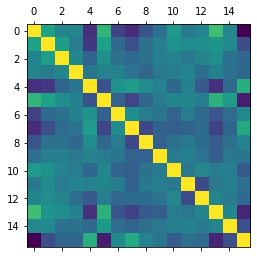

In [73]:
## compute rank correlations
rk_corr = train_val_reduc.corr(method="spearman")
print("Rank correlation:")
display(plt.matshow(rk_corr))

In [74]:
## significant rank correlations (|r|>0.4)
sig_corr = rk_corr[abs(rk_corr)>0.4]
sig_corr.replace(np.nan, "-", inplace=True)
sig_corr

,HeartDisease,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG_LVH,RestingECG_ST,ExerciseAngina,ST_Slope_Down,ST_Slope_Up
HeartDisease,1.0,-,-,-,-0.413251,0.436762,-,-0.42536,-,-,-,-,-,0.502205,-,-0.631526
Age,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-
RestingBP,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-
Cholesterol,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-
MaxHR,-0.413251,-,-,-,1.0,-,-,-,-,-,-,-,-,-0.410103,-,-
Oldpeak,0.436762,-,-,-,-,1.0,-,-,-,-,-,-,-,0.417747,-,-0.502399
Sex_F,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-
ChestPainType_ATA,-0.42536,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-
ChestPainType_NAP,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-
ChestPainType_TA,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-


**Conclusions**:
*   *HeartDisease* has a rank correlation of +0.4 or more with *ExerciseAngina* & *Oldpeak*, and of -0.4 or less with *MaxHR*, *ChestPainType_ATA*, and *ST_Slope_Up*.
*   Also, *ExerciseAngina* & *Oldpeak* are significantly positively associated. Further, *ExerciseAngina* & *MaxHR*, *Oldpeak* & *ST_Slope_Up*, and *ExerciseAngina* & *ST_Slope_Up* are significantly negatively correlated.
*   Hence, among the observed variables, ...

## **Q2: Logistic Lasso Regression**

Standardization usually improves accuracy and variable selection, while only slightly affecting the interpretability of the coefficients. Although thinkable, we do *not* standardize categorical variables, as this would excessively affect interpretability.

Hence, for the purposes of modelling, the further preprocessing pipeline consists of the following steps:

*   For categorical features:
  1.  Get back dummy variables for *each* category (justification later)

*  For continuous features
  1.   Impute missing values (incl. unrealistic 0 values) with the mean
  2.   Standardize to mean 0 and standard deviation 1
  3.   Create dummy variable for *Cholesterol = 0*

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

# impute missing values
train_val_proc_2 = pd.DataFrame(
    imputer.fit_transform(train_val_proc_1),
    columns = train_val_proc_1.columns)
test_proc_2 = pd.DataFrame(
    imputer.fit_transform(test_proc_1),
    columns = test_proc_1.columns)

# standardize numerical features
train_val_proc_2[num_fts] = scaler.fit_transform(train_val_proc_2[num_fts])
test_proc_2[num_fts] = scaler.fit_transform(test_proc_2[num_fts])

In [ ]:
X_train_val = train_val_proc_2.drop("HeartDisease", axis=1)
X_test = test_proc_2.drop("HeartDisease", axis=1)

y_train_val = train_val_proc_2["HeartDisease"]
y_test = test_proc_2["HeartDisease"]

When using regularization, we need to account for the fact that we introduced dummy variables. Specifically, we want to regularize the inclusion of entire variables, e.g. "Sex", and not certain categories, e.g. "Female", as this would introduce bias depending on the default category. To tackle this, we purposefully introduce all categories of categorical variables again and use **Group Lasso**. Altough this usually introduces multicollinearity, regularization serves to deal with this.

In [93]:
!pip install group-lasso
from group_lasso import LogisticGroupLasso

group_names = ["Chol_NA", "Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
               "Sex", "ChestPain", "FastingBS", "RestingECG", "ExerciseAngina",
               "ST_Slope"]
group_sizes = [1, 1, 1, 1, 1, 1,
               2, 4, 2, 3, 2, 3]
n_groups = len(group_sizes)
groups = np.concatenate([size * [i] for i, size in enumerate(group_sizes)])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

p1_vals = 2.0**np.arange(-10, 0)
scores = []

for i in range(len(p1_vals)):
  lgl = LogisticGroupLasso(
      groups = groups,
      group_reg = p1_vals[i],
      l1_reg = 0.0,
      scale_reg = "inverse_group_size",
      subsampling_scheme = 1,
      supress_warning = True)

  result = cross_validate(lgl, X_train_val, y_train_val, scoring="f1", cv=5)
  score = result["test_score"].mean()
  scores.append(score)

p1_opt = p1_vals[np.argmax(scores)]
print("Optimal group penalty:", p1_opt)

NameError: ignored

In [88]:
lgl = LogisticGroupLasso(
    groups = groups,
    group_reg = p1_opt,
    l1_reg = p2,
    scale_reg = "inverse_group_size",
    subsampling_scheme = 1,
    supress_warning = True)

lgl.fit(X_train, y_train)

,Coef
Age,0.107761
RestingBP,-
Cholesterol,-
Chol_NA,0.264175
MaxHR,-0.069495
Oldpeak,0.292538
Sex_F,-0.489257
Sex_M,0.489257
ChestPainType_ASY,1.212086
ChestPainType_ATA,-0.678103


,Group Norm
Age,0.107761
RestingBP,-
Cholesterol,-
Chol_NA,0.264175
MaxHR,0.069495
Oldpeak,0.292538
Sex,0.978514
ChestPain,2.424172
FastingBS,0.700954
RestingECG,-


Model summary

In [ ]:
coeffs = lgl.coef_[:, 1] - lgl.coef_[:, 0]
coeffs = pd.DataFrame(coeffs, index=ft_names)
coeffs.columns = ["Coef"]

# examine group norms
group_norms = np.array([[np.nan]]*n_groups)
for i in range(n_groups):
  group_coeffs = coeffs.loc[groups==i,:].values
  group_norms[i,:] = np.linalg.norm(group_coeffs, ord=1)

group_norms = pd.DataFrame(group_norms,
                           index=group_names, columns=["Group Norm"])

# print result
coeffs.replace(0, "-", inplace=True)
group_norms.replace(0, "-", inplace=True)
display(coeffs)
display(group_norms)

Since continuous predictors have been standardized, their coefficients are to be interpreted as the effect of a 1 standard deviation increase of the variable on the log-odds of having heart disease, which are the following:

In [20]:
train_val_data.loc[:,cont_fts].std()

Age             9.421110
RestingBP      18.618490
Cholesterol    50.802178
MaxHR          25.334552
Oldpeak         1.082222
dtype: float64

Model performance

In [89]:
y_pred = lgl.predict(X_test)

              precision    recall  f1-score   support

        HD=1       0.85      0.88      0.87       100
        HD=0       0.90      0.88      0.89       121

    accuracy                           0.88       221
   macro avg       0.88      0.88      0.88       221
weighted avg       0.88      0.88      0.88       221



<AxesSubplot:>

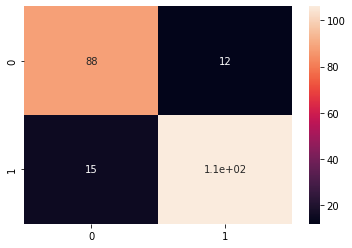

In [101]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_true=y_test, y_pred=y_pred, target_names=["HD=1", "HD=0"]))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sn.heatmap(conf_mat, annot=True)

Lastly, we note that Lasso selects only variables which are relevant for prediction, but that there is no guarantee of it identifying the *causal* variables. In our case, ...